In [24]:
import pickle
from collections import defaultdict, Counter
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate

In [4]:
print('Trigrams')
trigrams = pickle.load(open("trigrams.p", "rb"))
for k, v in trigrams.items():
    print(k, len(v))

print('\nSpeeches')
speeches = pickle.load(open("speeches.p", "rb"))
for k, v in speeches.items():
    print(k, len(v))
    
print('\nNew Pearsons')
new_pearsons = pickle.load(open("new_tri_pearsons.p", "rb"))
for k, v in new_pearsons.items():
    print(k, len(v))

Trigrams
106 50753
107 41164
108 50257
109 45242
110 54698
111 38688
112 37259
113 28968
114 22136

Speeches
106 141047
107 116076
108 127426
109 116822
110 129098
111 94078
112 90343
113 77180
114 67557

New Pearsons
108 21934
109 15443
110 21071
111 12780
112 11035
113 6634
114 5018


In [5]:
sorted_pearsons = sorted(new_pearsons[110].items(), key = lambda kv: kv[1])
d_pearsons = sorted_pearsons[:10]
r_pearsons = sorted_pearsons[-10:]
d_pearsons, r_pearsons

([(('oversight', 'govern', 'reform'), -0.00012133884752655807),
  (('iowa', 'public', 'school'), -0.00012009145643192981),
  (('committe', 'oversight', 'govern'), -0.00011370192061407879),
  (('room', '253', 'russel'), -6.436756784866624e-05),
  (('nation', 'like', 'take'), -6.146350101567532e-05),
  (('presid', 'iowa', 'across'), -6.146350101567532e-05),
  (('know', 'iowa', 'public'), -6.146350101567532e-05),
  (('student', 'test', 'score'), -6.0979492327798734e-05),
  (('iowa', 'across', 'unit'), -6.0979492327798734e-05),
  (('state', 'new', 'school'), -6.0979492327798734e-05)],
 [(('produc', 'american', 'energi'), 8.109534914459267e-05),
  (('2', 'trillion', 'barrel'), 8.247729418272946e-05),
  (('american', 'energi', 'product'), 9.671041331213571e-05),
  (('trillion', 'barrel', 'oil'), 0.00010572078422588108),
  (('nation', 'execut', 'committeeman'), 0.00011786147288005681),
  (('crude', 'oil', 'natur'), 0.00011850805888301626),
  (('protect', 'america', 'act'), 0.00012538527875228

In [6]:
source_dict = {}
sources = ["dkos", "motherjones", "nymag", "nypost", "townhall", "breitbart"]
for source in sources:
    file = open(source + '_trigrams_new.p', 'rb')
    source_dict[source] = pickle.load(file)
    file.close()

In [12]:
# number of articles per source
for source, articles in source_dict.items():
    print(source + ":", len(articles))

dkos: 96030
motherjones: 18534
nymag: 19324
nypost: 2119
townhall: 97730
breitbart: 84909


In [13]:
# number of total trigrams (only those found in new_trigrams) per source
counts = {source: sum([len(a['trigram']) for a in articles]) for source, articles in source_dict.items()}
[print(source + ":", counts[source]) for source in counts]
d_count = sum([count for source, count in counts.items() if source in ('dkos', 'motherjones', 'nymag')])
r_count = sum(counts.values()) - d_count
d_count, r_count

dkos: 367449
motherjones: 126516
nymag: 63577
nypost: 5082
townhall: 574804
breitbart: 399584


(557542, 979470)

In [14]:
# create a {trigram: [dates]} dictionary for each party, compiling sources into respective parties
d_news_trigrams = defaultdict(list)
for source in ('dkos', 'motherjones', 'nymag'):
    articles = source_dict[source]
    for article in articles:
        article_date = article['date']
        for trigram in article['trigram']:
            d_news_trigrams[trigram].append(article_date)
            
r_news_trigrams = defaultdict(list)
for source in ('nypost', 'townhall', 'breitbart'):
    articles = source_dict[source]
    for article in articles:
        article_date = article['date']
        for trigram in article['trigram']:
            r_news_trigrams[trigram].append(article_date)

In [15]:
print(len(d_news_trigrams), "democratic news trigrams")
print(sum([len(v) for k,v in d_news_trigrams.items()]), "democratic dates")
print(len(r_news_trigrams), "republican news trigrams")
print(sum([len(v) for k,v in r_news_trigrams.items()]), "republican dates")

57603 democratic news trigrams
557542 democratic dates
64747 republican news trigrams
979470 republican dates


In [102]:
# find the dates that each trigram was used in congress (split by democratic and republican)
def get_congress_trigram_dates(pearsons):
    congress_trigram_dates = {}
    for trigram in pearsons:
        trigram = trigram[0]
        d_dates = []
        r_dates = []
        for session in range(106,115):
            if trigram in trigrams[session]:
                speechIDs = trigrams[session][trigram]
                for speechID in speechIDs:
                    speech = speeches[session][speechID]
                    if speech['party'] == 'D':
                        d_dates.append(speech['date'])
                    else:
                        r_dates.append(speech['date'])
        congress_trigram_dates[trigram] = {'d_dates': d_dates, 'r_dates': r_dates}
    return congress_trigram_dates

# find the dates that each trigram was used in the news (split by democratic and republican)
def get_news_trigram_dates(pearsons):
    news_trigram_dates = {}
    for trigram in pearsons:
        trigram = trigram[0]
        d_dates = d_news_trigrams[trigram] if trigram in d_news_trigrams else []
        r_dates = r_news_trigrams[trigram] if trigram in r_news_trigrams else []
        news_trigram_dates[trigram] = {'d_dates': d_dates, 'r_dates': r_dates}
    return news_trigram_dates

# convert date lists to be number of days a trigram was used after it was first used in congress
def get_days_from_origin(congress_trigram_dates, news_trigram_dates):
    for trigram in congress_trigram_dates:
        congress_date_dict = congress_trigram_dates[trigram]
        congress_d_dates = [date(d['year'], d['month'], d['day']) for d in congress_date_dict['d_dates']]
        congress_r_dates = [date(d['year'], d['month'], d['day']) for d in congress_date_dict['r_dates']]
        
        news_date_dict = news_trigram_dates[trigram]
        news_d_dates = []
        for d in news_date_dict['d_dates']:
            day = 1 if 'day' not in d else d['day']
            news_d_dates.append(date(d['year'], d['month'], day))
        # news_d_dates = [date(d['year'], d['month'], d['day']) for d in news_date_dict['d_dates']]
        news_r_dates = [date(d['year'], d['month'], d['day']) for d in news_date_dict['r_dates']]
        
        origin = min(congress_d_dates + congress_r_dates)
        
        congress_trigram_dates[trigram]['d_dates'] = [(d - origin).days for d in congress_d_dates]
        congress_trigram_dates[trigram]['r_dates'] = [(d - origin).days for d in congress_r_dates]
        news_trigram_dates[trigram]['d_dates'] = [(d - origin).days for d in news_d_dates]
        news_trigram_dates[trigram]['r_dates'] = [(d - origin).days for d in news_r_dates]
        
    return congress_trigram_dates, news_trigram_dates

# compute averages of the democratic and republican trigram counts for each day
def average_phrases(trigram_dates):
    num_phrases = len(trigram_dates)
    d_counters = [Counter(date_dict['d_dates']) for date_dict in trigram_dates.values()]
    r_counters = [Counter(date_dict['r_dates']) for date_dict in trigram_dates.values()]
    d_counts = {k: v/num_phrases for k, v in sum(d_counters, Counter()).items()}
    r_counts = {k: v/num_phrases for k, v in sum(r_counters, Counter()).items()}
    d_x, d_y = zip(*sorted(d_counts.items()))
    r_x, r_y = zip(*sorted(r_counts.items()))
    return np.array(d_x), np.array(d_y), np.array(r_x), np.array(r_y)

def visualize(current_session, num_phrases, party):
    # obtain num_phrases most democratic or republican trigrams in current session
    sorted_pearsons = sorted(new_pearsons[current_session].items(), key = lambda kv: kv[1])
    pearsons = sorted_pearsons[:num_phrases] if party == 'D' else sorted_pearsons[-num_phrases:]
    # find the dates that each trigram was used in congress (split by democratic and republican)
    congress_trigram_dates = get_congress_trigram_dates(pearsons)
    # find the dates that each trigram was used in the news (split by democratic and republican)
    news_trigram_dates = get_news_trigram_dates(pearsons)
    # convert date lists to be number of days a trigram was used after it was first used in congress
    congress_trigram_dates, news_trigram_dates = get_days_from_origin(congress_trigram_dates, news_trigram_dates)
    # compute averages of the democratic and republican trigram counts for each day in congress
    congress_d_x, congress_d_y, congress_r_x, congress_r_y = average_phrases(congress_trigram_dates)
    # compute averages of the democratic and republican trigram counts for each day in news
    news_d_x, news_d_y, news_r_x, news_r_y = average_phrases(news_trigram_dates)
    # plot trigram use over time
    order = 1 if party == 'D' else 3
    plt.plot(congress_d_x, congress_d_y, zorder = order)
    plt.plot(congress_r_x, congress_r_y)
    plt.plot(news_d_x, news_d_y)
    plt.plot(news_r_x, news_r_y)
    plt.legend(['Congress D', 'Congress R', 'News D', 'News R'], loc = 'upper right')
#     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
    plt.xlim((-30, 500))
    plt.ylim((0, 0.5))
    plt.show()

In [103]:
def visualize_congress(current_session, num_phrases, party):
    # obtain num_phrases most democratic or republican trigrams in current session
    sorted_pearsons = sorted(new_pearsons[current_session].items(), key = lambda kv: kv[1])
    pearsons = sorted_pearsons[:num_phrases] if party == 'D' else sorted_pearsons[-num_phrases:]
    # find the dates that each trigram was used in congress (split by democratic and republican)
    congress_trigram_dates = get_congress_trigram_dates(pearsons)
    # find the dates that each trigram was used in the news (split by democratic and republican)
    news_trigram_dates = get_news_trigram_dates(pearsons)
    # convert date lists to be number of days a trigram was used after it was first used in congress
    congress_trigram_dates, news_trigram_dates = get_days_from_origin(congress_trigram_dates, news_trigram_dates)
    # compute averages of the democratic and republican trigram counts for each day in congress
    return average_phrases(congress_trigram_dates)
    
def visualize_news(current_session, num_phrases, party):
    # obtain num_phrases most democratic or republican trigrams in current session
    sorted_pearsons = sorted(new_pearsons[current_session].items(), key = lambda kv: kv[1])
    pearsons = sorted_pearsons[:num_phrases] if party == 'D' else sorted_pearsons[-num_phrases:]
    # find the dates that each trigram was used in congress (split by democratic and republican)
    congress_trigram_dates = get_congress_trigram_dates(pearsons)
    # find the dates that each trigram was used in the news (split by democratic and republican)
    news_trigram_dates = get_news_trigram_dates(pearsons)
    # convert date lists to be number of days a trigram was used after it was first used in congress
    congress_trigram_dates, news_trigram_dates = get_days_from_origin(congress_trigram_dates, news_trigram_dates)
    # compute averages of the democratic and republican trigram counts for each day in news
    return average_phrases(news_trigram_dates)

In [35]:
current_session = 110
num_phrases = 1000
party = 'D'
congress_d_x, congress_d_y, congress_r_x, congress_r_y = visualize_congress(current_session, num_phrases, party)
news_d_x, news_d_y, news_r_x, news_r_y = visualize_news(current_session, num_phrases, party)

In [26]:
def smooth(arr, K):
    smoothed_arr = []
    for i, _ in enumerate(arr):
        low = max(0, i - K//2)
        high = min(i + K//2 + 1, len(arr))
        window = arr[low:high]
        smoothed_value = sum(window) / len(window)
        smoothed_arr.append(smoothed_value)
    return smoothed_arr

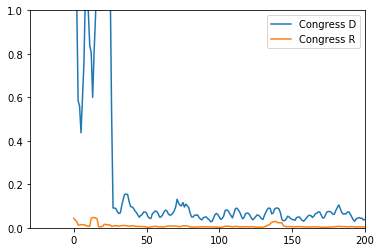

In [36]:
# plot trigram use over time
order = 1 if party == 'D' else 3
plt.plot(congress_d_x, smooth(congress_d_y, 5), zorder = order)
plt.plot(congress_r_x, smooth(congress_r_y, 5))
plt.legend(['Congress D', 'Congress R'], loc = 'upper right')
#     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
plt.xlim((-30, 200))
plt.ylim((0, 1))
plt.show()

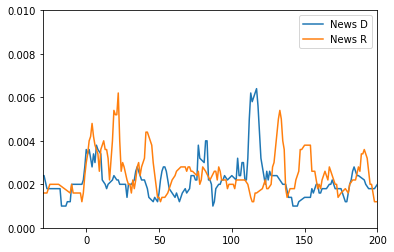

In [38]:
# plot trigram use over time
order = 1 if party == 'D' else 3
plt.plot(news_d_x, smooth(news_d_y, 5), zorder = order)
plt.plot(news_r_x, smooth(news_r_y, 5))
plt.legend(['News D', 'News R'], loc = 'upper right')
#     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
plt.xlim((-30, 200))
plt.ylim((0, .01))
plt.show()

In [ ]:
# sliding window
# in following year, used at least alpha times in the media

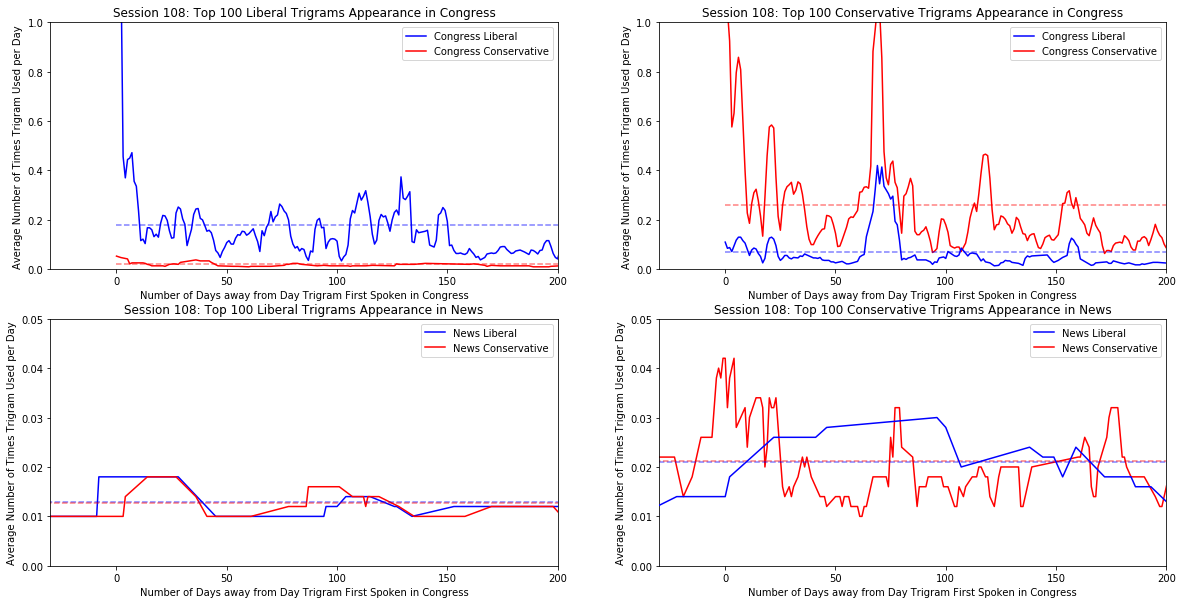

In [120]:
plt.figure(figsize=(20,10))
current_session = 108
num_phrases = 100

for party in ('D', 'R'):
    congress_d_x, congress_d_y, congress_r_x, congress_r_y = visualize_congress(current_session, num_phrases, party)
    d_y_mean = [np.mean(congress_d_y[np.where((-30 <= congress_d_x) & (congress_d_x <= 200))])]*len(congress_d_x)
    r_y_mean = [np.mean(congress_r_y[np.where((-30 <= congress_r_x) & (congress_r_x <= 200))])]*len(congress_r_x)
    plt.subplot(2, 2, (party == 'R')+1)
    party_label = 'Liberal' if party == 'D' else 'Conservative'
    plt.title('Session ' + str(current_session) + ': Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams Appearance in Congress')
    plt.plot(congress_d_x, smooth(congress_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
    plt.plot(congress_r_x, smooth(congress_r_y, 5), color = 'r')
    plt.plot(congress_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
    plt.plot(congress_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
    plt.legend(['Congress Liberal', 'Congress Conservative'], loc = 'upper right')
    #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
    plt.xlabel('Number of Days away from Day Trigram First Spoken in Congress')
    plt.ylabel('Average Number of Times Trigram Used per Day')
    plt.xlim((-30, 200))
    plt.ylim((0, 1))

for party in ('D', 'R'):
    news_d_x, news_d_y, news_r_x, news_r_y = visualize_news(current_session, num_phrases, party)
    d_y_mean = [np.mean(news_d_y[np.where((-30 <= news_d_x) & (news_d_x <= 200))])]*len(news_d_x)
    r_y_mean = [np.mean(news_r_y[np.where((-30 <= news_r_x) & (news_r_x <= 200))])]*len(news_r_x)
    plt.subplot(2, 2, (party == 'R')+3)
    party_label = 'Liberal' if party == 'D' else 'Conservative'
    plt.title('Session ' + str(current_session) + ': Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams Appearance in News')
    plt.plot(news_d_x, smooth(news_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
    plt.plot(news_r_x, smooth(news_r_y, 5), color = 'r')
    plt.plot(news_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
    plt.plot(news_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
    # dashed lines
    plt.legend(['News Liberal', 'News Conservative'], loc = 'upper right')
    #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
    plt.xlabel('Number of Days away from Day Trigram First Spoken in Congress')
    plt.ylabel('Average Number of Times Trigram Used per Day')
    plt.xlim((-30, 200))
    plt.ylim((0, 0.05))
    
plt.show()

In [122]:
def full_visualizations(current_session, num_phrases):
    plt.figure(figsize=(20,10))
    for party in ('D', 'R'):
        congress_d_x, congress_d_y, congress_r_x, congress_r_y = visualize_congress(current_session, num_phrases, party)
        d_y_mean = [np.mean(congress_d_y[np.where((-30 <= congress_d_x) & (congress_d_x <= 200))])]*len(congress_d_x)
        r_y_mean = [np.mean(congress_r_y[np.where((-30 <= congress_r_x) & (congress_r_x <= 200))])]*len(congress_r_x)
        plt.subplot(2, 2, (party == 'R')+1)
        party_label = 'Liberal' if party == 'D' else 'Conservative'
        plt.title('Session ' + str(current_session) + ': Use of Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams in Congress Over Time')
        plt.plot(congress_d_x, smooth(congress_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
        plt.plot(congress_r_x, smooth(congress_r_y, 5), color = 'r')
        plt.plot(congress_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
        plt.plot(congress_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
        plt.legend(['Congress Liberal', 'Congress Conservative'], loc = 'upper right')
        #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
        plt.xlabel('Number of Days Away From First Day Trigram Spoken in Congress')
        plt.ylabel('Number of Times Average Trigram Used per Day')
        plt.xlim((-30, 200))
        plt.ylim((0, 1))

    for party in ('D', 'R'):
        news_d_x, news_d_y, news_r_x, news_r_y = visualize_news(current_session, num_phrases, party)
        d_y_mean = [np.mean(news_d_y[np.where((-30 <= news_d_x) & (news_d_x <= 200))])]*len(news_d_x)
        r_y_mean = [np.mean(news_r_y[np.where((-30 <= news_r_x) & (news_r_x <= 200))])]*len(news_r_x)
        plt.subplot(2, 2, (party == 'R')+3)
        party_label = 'Liberal' if party == 'D' else 'Conservative'
        plt.title('Session ' + str(current_session) + ': Use of Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams in News Over Time')
        plt.plot(news_d_x, smooth(news_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
        plt.plot(news_r_x, smooth(news_r_y, 5), color = 'r')
        plt.plot(news_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
        plt.plot(news_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
        # dashed lines
        plt.legend(['News Liberal', 'News Conservative'], loc = 'upper right')
        #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
        plt.xlabel('Number of Days Away From First Day Trigram Spoken in Congress')
        plt.ylabel('Number of Times Average Trigram Used per Day')
        plt.xlim((-30, 200))
        plt.ylim((0, 0.2))

    plt.show()

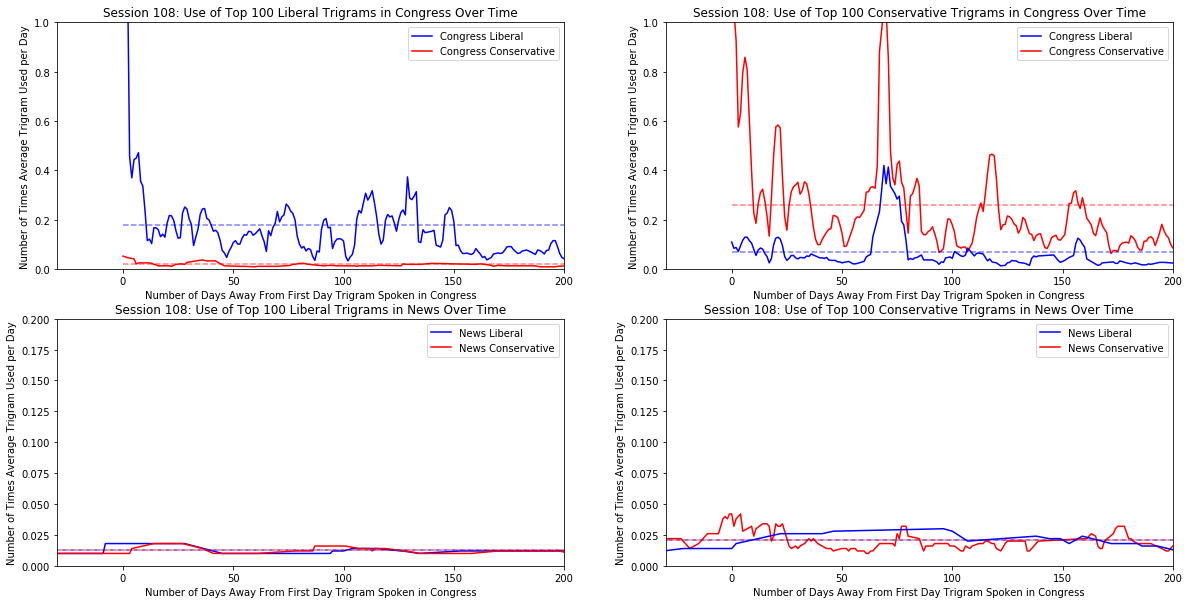

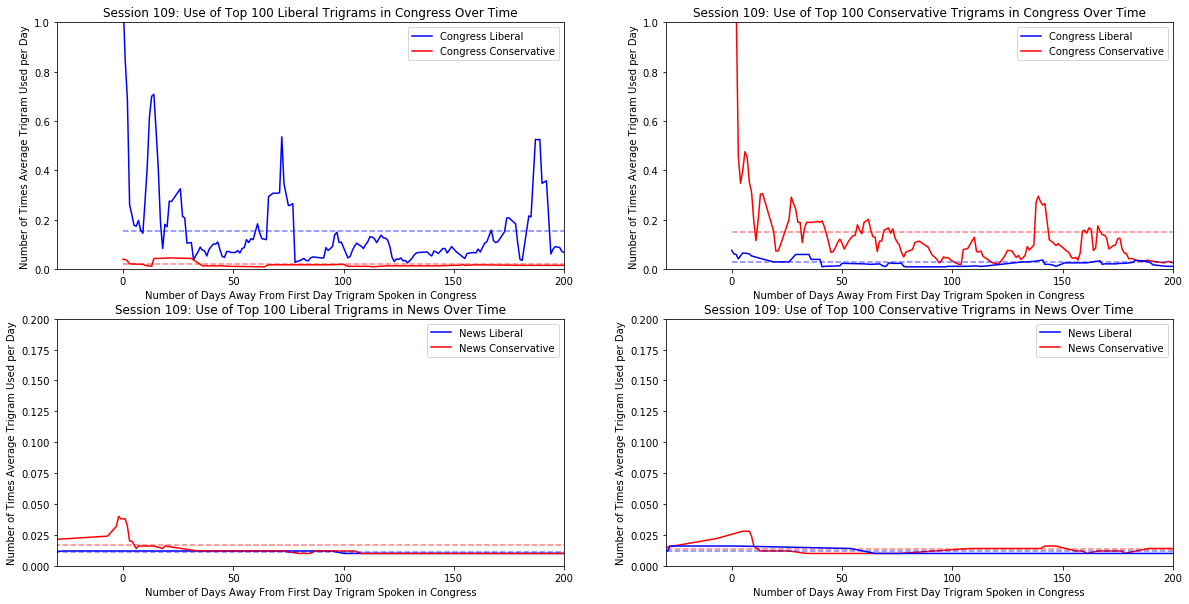

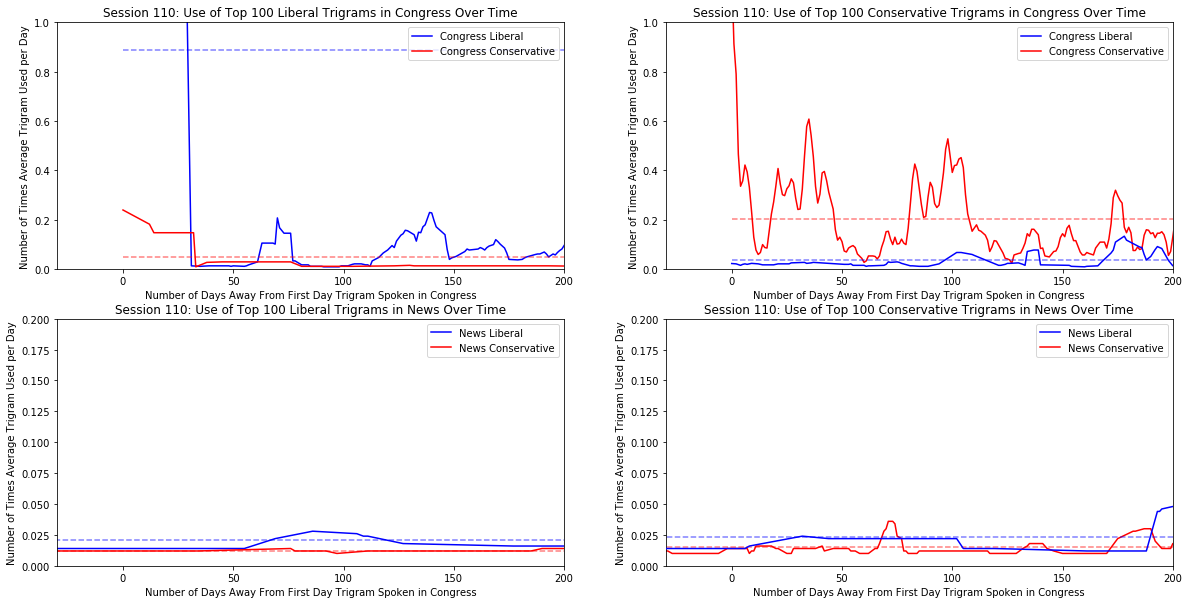

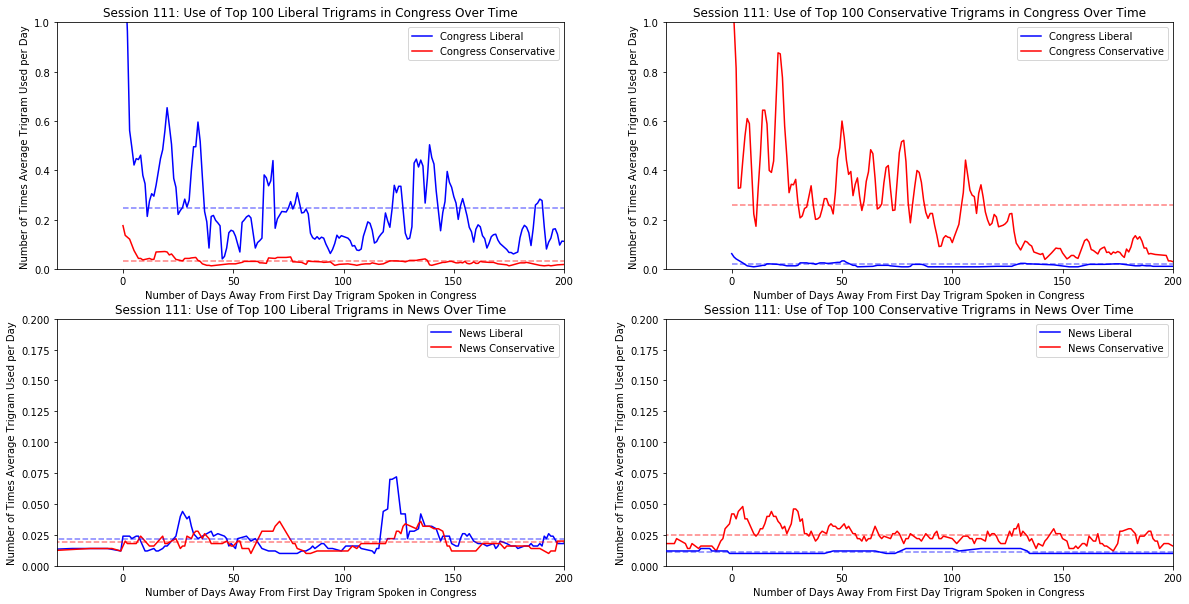

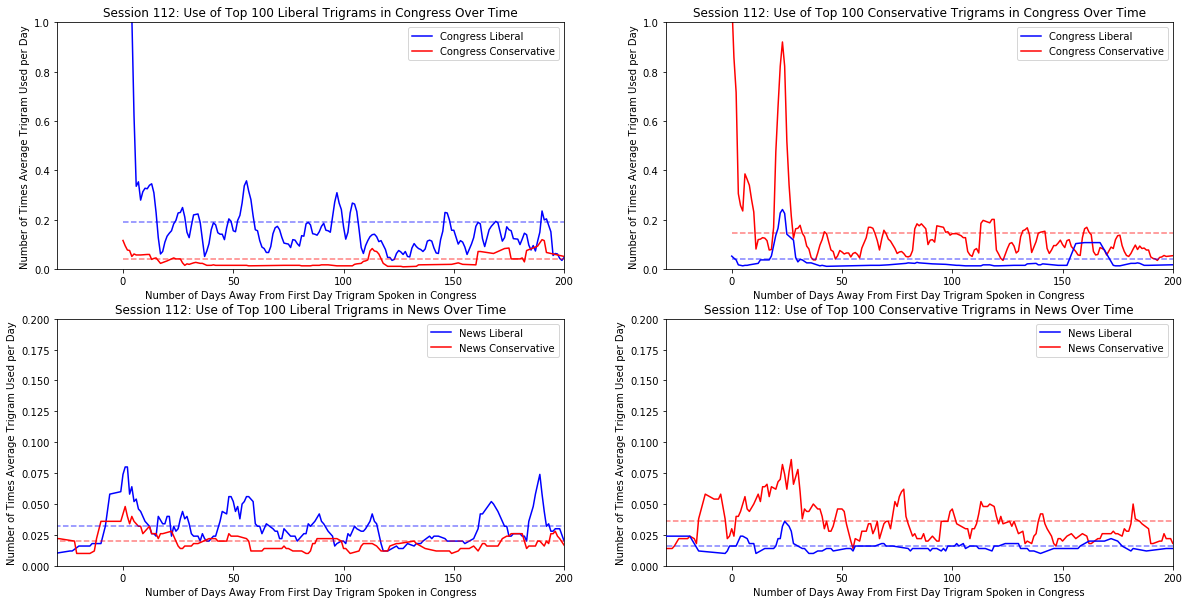

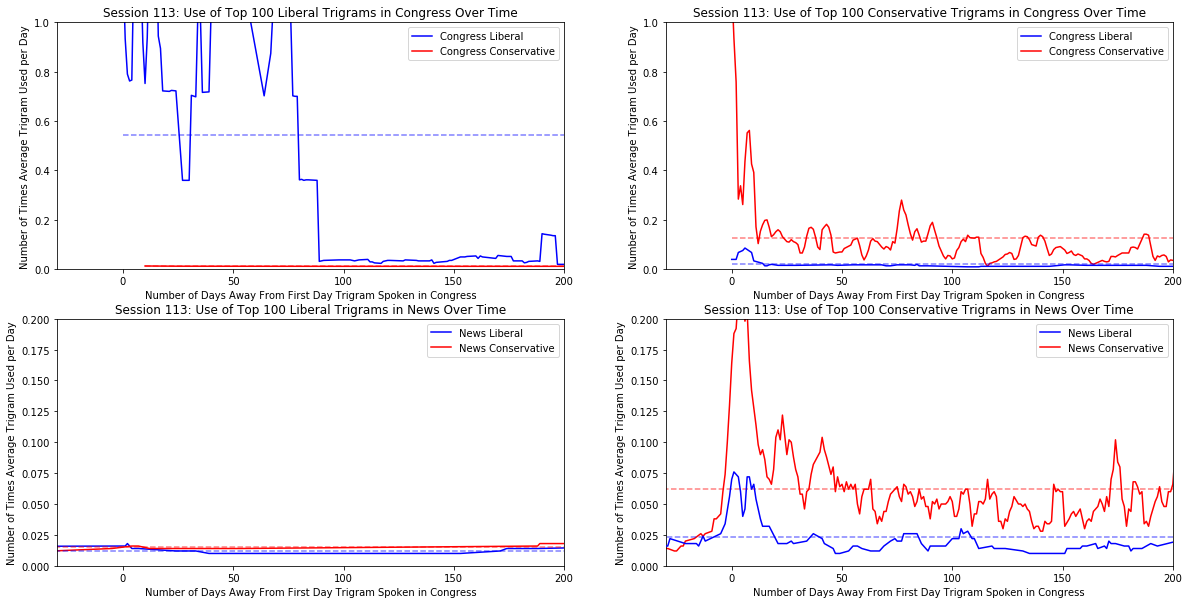

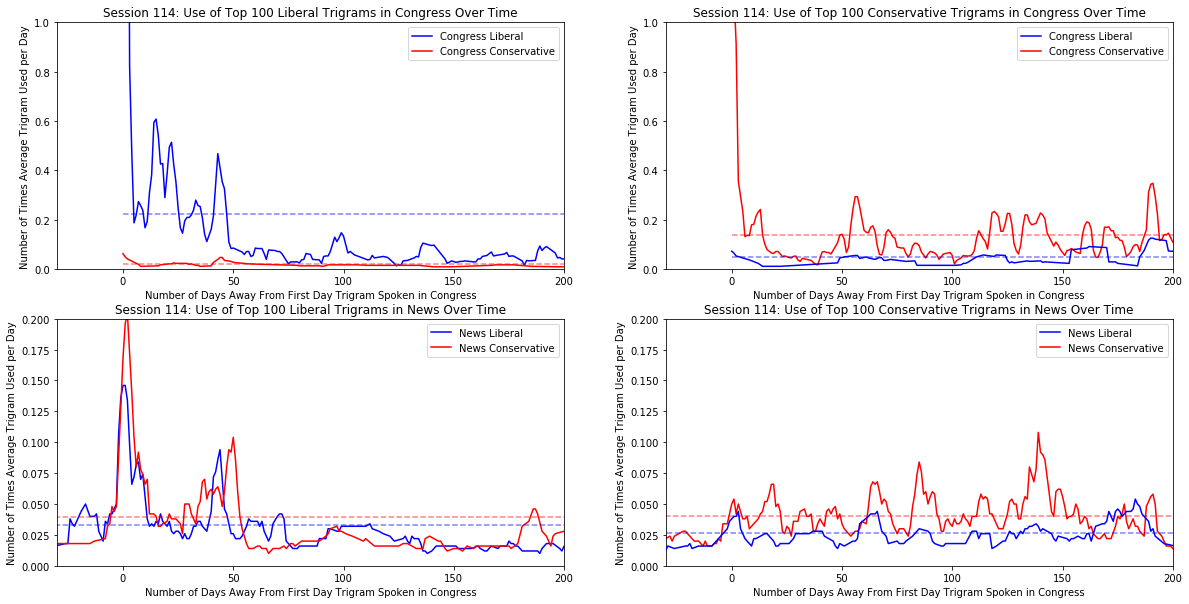

In [123]:
# current_session = 111
num_phrases = 100
for current_session in range(108,115):
    full_visualizations(current_session, num_phrases)